FaceValue Bioinstrumentation Project | Coded by Cata Santos Anzola | Finished

cata comment: please run the arduino code before running this code! This code will receive the serial output from the arduino (stored in the SD card), and put it through our EMG-classifying model. The outcome of the model will then print out a string that will be sent to the arduino to show on the LCD.

Step 0. Import libraries

In [42]:
# initialize all libraries
import numpy as np
import joblib
import keras
from keras.models import load_model
import tensorflow as tf
import serial
import pickle
import sys
import inspect
from pyfirmata2 import Arduino
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import tensorflow.keras.config as tfconfig
tfconfig.enable_unsafe_deserialization()

Step 1. Connect with Arduino

In [43]:
# auto detect COM port so we don't have to change it everytime
PORT = Arduino.AUTODETECT
PINS = [1, 2, 3, 4, 5]  # A1 through A5
SAMPLING_RATE = 10  # Hz
DATA_DIR = "EMG_recordings"
os.makedirs(DATA_DIR, exist_ok=True)

Step 2. Collect EMG Signals and Save as CSV into SD Card (SD too fat to work rn)

In [27]:
class MultiSensorRecorder:
    def __init__(self):
        self.recording = False
        self.recording_count = 0
        self.data = {pin: [] for pin in PINS}
        
        print("Connecting to Arduino...")
        self.board = Arduino(PORT)
        
        # Setup callbacks
        self.setup_callbacks()
        
        # Start sampling
        self.board.samplingOn(1000 / SAMPLING_RATE)
        
        print("Connected!")
        
    def setup_callbacks(self):
        def make_callback(pin):
            def callback(value):
                if self.recording:
                    timestamp = time.time() - self.start_time
                    voltage = value * 0.05
                    self.data[pin].append([timestamp, voltage])
                    # Print update from first pin only
                    if pin == PINS[0] and len(self.data[pin]) % 10 == 0:
                        print(f"  {timestamp:.1f}s: {voltage:.3f}V", end='\r')
            return callback
        
        # Register callbacks
        for pin in PINS:
            self.board.analog[pin].register_callback(make_callback(pin))
    
    def start_recording(self):
        if self.recording:
            print("Already recording!")
            return
            
        self.recording = True
        self.recording_count += 1
        self.start_time = time.time()
        
        # Clear previous data
        self.data = {pin: [] for pin in PINS}
        
        # Enable reporting for all pins
        for pin in PINS:
            self.board.analog[pin].enable_reporting()
        
        print(f"\nRecording #{self.recording_count} started...")
    
    def stop_recording(self):
        if not self.recording:
            print("Not recording!")
            return
            
        self.recording = False
        
        # Disable reporting
        for pin in PINS:
            self.board.analog[pin].disable_reporting()
        
        time.sleep(0.5)  # Let any pending callbacks finish
        
        # Save data
        self.save_data()
        
        return self.data
    
    def save_data(self):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        print(f"\nSaving recording")
        
        for pin in PINS: # save everything to csv files and label columns for clear extraction and putting into the model
            if self.data[pin]:
                df = pd.DataFrame(self.data[pin], columns=["Time", "Voltage"])
                filename = f"A{pin}_5.csv"
                filepath = os.path.join(DATA_DIR, filename)
                df.to_csv(filepath, index=False)
                print(f"  A{pin}: {len(df)} samples -> {filename}")
            else:
                print(f"  A{pin}: No data collected")
    
    def record_for_duration(self, duration):
        self.start_recording()
        time.sleep(duration)
        return self.stop_recording()
    
    def close(self):
        self.board.samplingOff()
        time.sleep(0.1)
        self.board.exit()
        print("Arduino connection closed")

def simple_automatic_recording():
    recorder = MultiSensorRecorder()
    recording_num = 0
    try:
        print("Scrunch your face after the countdown..all pins (A1-A5) will be recorded.")
        while True:
            recording_num += 1
            duration = 5 # 5 second recording time
            # Countdown
            print(f"\nStarting in...")
            for i in range(3, 0, -1):
                print(f"{i}...")
                time.sleep(1)
            print("RECORDING!")
            # Record
            recorder.record_for_duration(duration)
            print(f"\nRecording complete!")
            
            # Ask to continue
            cont = input("\nRecord another? (y/n): ").lower() # in case we mess up the first one we can add/replace the last one
            if cont != 'y':
                break
    except KeyboardInterrupt:
        print("\n\nStopped by user")
    except Exception as e:
        print(f"\nError: {e}")
    finally:
        recorder.close()
        print(f"Data saved in: {DATA_DIR}")

        
# Run the program ughhhh
if __name__ == "__main__":
    simple_automatic_recording()
 

Connecting to Arduino...
Connected!
Scrunch your face after the countdown..all pins (A1-A5) will be recorded.

Starting in...
3...
2...
1...
RECORDING!

Recording #1 started...
  4.9s: 0.014V
Saving recording
  A1: 51 samples -> A1_5.csv
  A2: 51 samples -> A2_5.csv
  A3: 51 samples -> A3_5.csv
  A4: 51 samples -> A4_5.csv
  A5: 51 samples -> A5_5.csv

Recording complete!
Arduino connection closed
Data saved in: EMG_recordings


Step 3. Visualize graphs to make sure we are on the right track (and also importing the right csv files from the SD card)

Text(0.5, 1.0, 'left jaw EMG')

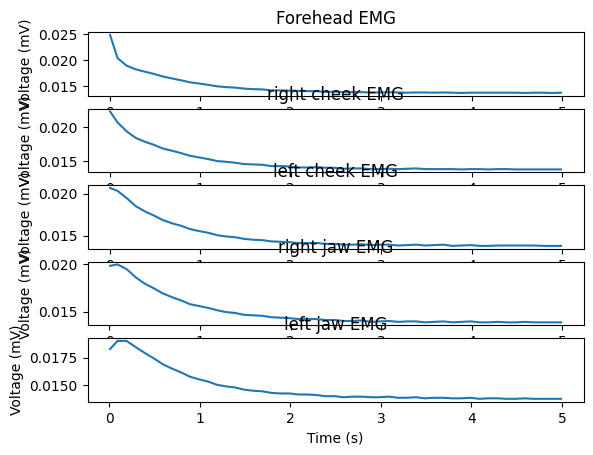

In [44]:
# change these to SD card directory once we have it plugged into the Arduino. Figure out how to access this then as it technically is optional
head = pd.read_csv("C:/Users/catas/OneDrive - Clemson University/Uni/Bioinstrumentation Lab/FaceValue/FaceValue_ML/EMG_recordings/A1_5.csv")
cheek1 = pd.read_csv("C:/Users/catas/OneDrive - Clemson University/Uni/Bioinstrumentation Lab/FaceValue/FaceValue_ML/EMG_recordings/A2_5.csv")
cheek2 = pd.read_csv("C:/Users/catas/OneDrive - Clemson University/Uni/Bioinstrumentation Lab/FaceValue/FaceValue_ML/EMG_recordings/A3_5.csv")
jaw1 = pd.read_csv("C:/Users/catas/OneDrive - Clemson University/Uni/Bioinstrumentation Lab/FaceValue/FaceValue_ML/EMG_recordings/A4_5.csv")
jaw2 = pd.read_csv("C:/Users/catas/OneDrive - Clemson University/Uni/Bioinstrumentation Lab/FaceValue/FaceValue_ML/EMG_recordings/A5_5.csv")

plt.figure()
plt.subplot(511)
plt.plot(head.Time,head.Voltage) #plotting of forehead signal
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (s)')
plt.title('Forehead EMG')

plt.subplot(512)
plt.plot(cheek1.Time,cheek1.Voltage) #plotting of forehead signal
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (s)')
plt.title('right cheek EMG')

plt.subplot(513)
plt.plot(cheek2.Time,cheek2.Voltage) #plotting of forehead signal
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (s)')
plt.title('left cheek EMG')

plt.subplot(514)
plt.plot(jaw1.Time,jaw1.Voltage) #plotting of forehead signal
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (s)')
plt.title('right jaw EMG')

plt.subplot(515)
plt.plot(jaw2.Time,jaw2.Voltage) #plotting of forehead signal
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (s)')
plt.title('left jaw EMG')

Step 3. Run EMG signal into Calibration Curve Metrics for classification

In [45]:
# knowing our calibration curve min/max values, we can classify our signal for whether it's below or above our lowest non-control signal value)
if max(abs(head.Voltage)) > 0.0190:
    signal1 = 0
else:
    signal1 = 1

if max(abs(cheek1.Voltage)) > 0.0190:
    signal2 = 0
else:
    signal2 = 1

if max(abs(cheek2.Voltage)) > 0.0190:
    signal3 = 0
else:
    signal3 = 1

if max(abs(jaw1.Voltage)) > 0.0190:
    signal4 = 0
else:
    signal4 = 1

if max(abs(jaw2.Voltage)) > 0.0190:
    signal5 = 0
else:
    signal5 = 1

if (signal1 & signal2 & signal3 & signal4 & signal5) == 0:
    signal = "ALS not suspected"
else:
    signal = "ALS suspected"

print(signal) # uncomment this to check output

ALS not suspected


In [ ]:
# grab model and input if accuracy above 70% we will prefer this, if not, override model prediction with string.
# keras.config.enable_unsafe_deserialization()
# model = load_model('C:/Users/catas/OneDrive - Clemson University/Uni/Bioinstrumentation Lab/FaceValue/ALSdata/emg_als_classifier_final.h5')


Step 4. Send Decision String to LCD screen for final output

In [1]:
# import time
# from pyfirmata2 import Arduino


# Arduino.exit()

In [ ]:
# # run each EMG signal through the ML model ughghghghghghdkfghkadlkslkjhaslidghs i don't wanna be here anymore
# # def data(a): # define function to switch between pins and get outcome from each, this is lame but i cannot be bothered to make it nicer bruh its 9 am leave me alone
# #     if a == 1:
# #         data =[head.Time, head.Voltage]
# #         print(data)
# #     elif a == 2:
# #         data = [cheek1.Time, cheek1.Voltage]
# #     elif a == 3:
# #         data = [cheek2.Time, cheek2.Voltage]
# #     elif a == 4:
# #         data = [jaw1.Time, jaw2.Voltage]
# #     elif a == 5:
# #         data = [jaw2.Time, jaw2.Voltage]
# #     return data
# data = [head.Time, head.Voltage]
# outcome = model.predict(data)
# print(outcome)
#  # input each signal lead thingy into the function
# a=1
# while a<6:
#     outcome = model.predict(data) #get the prediction from the model based on the data from SD card
#     print(outcome) #print this so we can see it as we run & trouble shoot, comment out later if needed
#     a = a+1

# # #cata comment: this inequality isn't final as we need to see how each EMG weighs into the prediction.
# # if outcome != 0:
# #     stringa = 'ALS Suspected'
# # else:
# #     stringa = 'ALS Not Suspected'

Step 4. output string from model result to arduino

In [ ]:
# 

           ,....,
        ,;;:o;;;o;;,
      ,;;o;'''''';;;;,
     ,;:;;        ;;o;,
     ;o;;          ;;;;        Happy Holidays <3
     ';;;,  _  _  ,;;;'
      ';o;;/_\/_\;;o;'
         ';;\_\/_/;;'
           '//\\'
           //  \\
          |/    \|